In [1]:
# set up 
import json
from dataclasses import asdict
import sys
from matplotlib import pyplot as plt
import pandas as pd

sys.path.append('/mnt/c/Users/neilm/Documents/Drawdown/glass-wing/solutions')
from model.ocean_unit_adoption import UnitAdoption

pds_adoption_file = '/mnt/c/Users/neilm/Documents/Drawdown/glass-wing/solutions/solution/seaweedfarming/unit_adoption_data/custom_pds_adoption.json'
ref_adoption_file = '/mnt/c/Users/neilm/Documents/Drawdown/glass-wing/solutions/solution/seaweedfarming/unit_adoption_data/custom_ref_adoption.json'
base_year = 2015
start_year = 2020
end_year = 2050
total_ocean_area = 240
pds_scenario_name = 'Average of All Custom Scenarios'
ref_scenario_name = 'Custom'
region = 'World'

SolutionData = {
    '_first_cost': 9705.64312711705,
    '_operating_cost': 11585.8860579587,
    '_net_profit_margin': 12892.9642297685,
    '_expected_lifetime': 30
    }

def _load_adoption_scenario(adoption_input_file, adoption_scenario_name, extra_adoption_info):

        stream = open(adoption_input_file,'r')
        adoption_dict = json.load(stream)

        adoption_scenario_desc = [k for k, v in adoption_dict.items() if v['description'] == adoption_scenario_name]
        
        if len(adoption_scenario_desc) == 0:
            raise ValueError(f'No matching adoption scenario for key {adoption_scenario_name}')
        if len(adoption_scenario_desc) > 1:
            raise ValueError(f'More than one matching adoption scenario for key {adoption_scenario_name}')

        adoption_scenario_desc = adoption_scenario_desc.pop()

        try:
            adoption_scenario = adoption_dict[adoption_scenario_desc]
        except ValueError as ex:
            print(ex.args)
            raise ValueError(f'Unable to find adoption scenario: {adoption_scenario_name} in input file: {adoption_input_file}')
            
        desc = adoption_scenario['description']
        cols = adoption_scenario['regions']
        idx = adoption_scenario['time_periods']
        data = adoption_scenario['data']

        try:
            ad_scenario = UnitAdoption(desc, cols, idx, data, base_year, **extra_adoption_info)
        except ValueError as ev:
            print(ev.args)
            raise ValueError(f"Unable to initialise {adoption_scenario_name}")
        
        return ad_scenario

pds_scenario = _load_adoption_scenario(pds_adoption_file, pds_scenario_name, SolutionData)
ref_scenario = _load_adoption_scenario(ref_adoption_file, ref_scenario_name, SolutionData)


In [2]:
# First Cost calculation

# awfc = Annual World First Cost
pds_awfc = pds_scenario.get_annual_world_first_cost(region) # see cell [First Cost]!$E$36
ref_awfc = ref_scenario.get_annual_world_first_cost(region) # see cell [First Cost]!$N$36

pds_fc = pds_awfc.loc[2014:2050].sum()
ref_fc = ref_awfc.loc[2014:2050].sum()

final_fc = pds_fc - ref_fc
print(final_fc / 1000)


132.13729264924882


In [4]:
disturbance_rate = 0.02
region = 'World'
base_year = 2020
end_year = 2050

# TODO: confirm start_year-1 is desired. Why does it start in 2019?

pds_series = pds_scenario.get_operating_cost(region, end_year) * (1+ disturbance_rate)
pds_result = pds_series.cumsum().loc[end_year] - pds_series.cumsum().loc[start_year]

# should be (conventional_result - pds_result). No conventional for seaweed farming.
result = - pds_result / 1000 # in billions

print(result)

-2559.622235804863


In [5]:
# lifetime operating savings

disturbance_rate = 0.02
region = 'World'
base_year = 2020
end_year = 2050

lifetime_values = [20,25,30,35,40]
plot_series = pd.DataFrame(index=range(base_year, 2100))

for life_val in lifetime_values:
    pds_scenario.expected_lifetime = life_val
    pds_series = pds_scenario.get_lifetime_operating_savings(region, end_year) * (1+ disturbance_rate)
    plot_series[life_val] = pds_series

pds_scenario.expected_lifetime = 30


<AxesSubplot:>

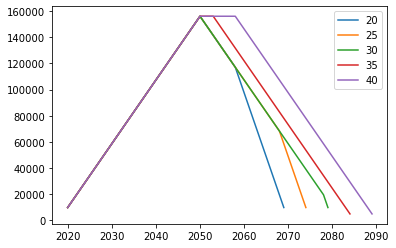

In [22]:
plot_series.plot(kind='line')

In [6]:
# lifetime operating savings

disturbance_rate = 0.02
region = 'World'
base_year = 2020
end_year = 2050

base_op_cost = pds_scenario.operating_cost
print(base_op_cost)

op_cost_shifts = [0.6, 0.8, 1.0, 1.2, 1.4]
plot_series = pd.DataFrame(index=range(base_year, 2100))

for cost_shift in op_cost_shifts:
    pds_scenario.operating_cost = base_op_cost * cost_shift
    pds_series = pds_scenario.get_lifetime_operating_savings(region, end_year) * (1+ disturbance_rate)
    plot_series[cost_shift] = pds_series

pds_scenario.operating_cost = base_op_cost


11585.8860579587


<AxesSubplot:>

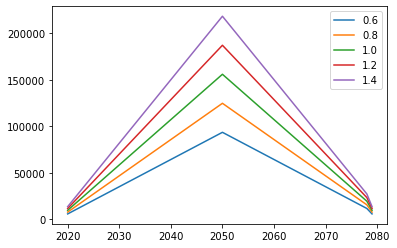

In [24]:
plot_series.plot(kind='line')